In [ ]:
! nvidia-smi
! pip install transformers datasets
! pip install huggingface_hub
! pip install sentencepiece
! gdown 1SLkoO3mD7bpV8B7UpcDeuPHIOF3bFLPp
! unzip Dataset.zip

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DefaultDataCollator, AutoModelForQuestionAnswering
from transformers import TrainingArguments, Trainer, create_optimizer, pipeline
import json
import pandas as pd
import datasets
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [9]:
DATASETS = {
    "pquad": 0,
    "persian_qa": 1,
    "parsquad": 2,
    "pquad_and_persian_qa": 3
}

class DatasetLoader:
    def __init__(self, dataset, tokenizer):
        self.tokenizer = tokenizer
        self.dataset = datasets.DatasetDict()
        dataset_to_loader = {
            DATASETS["pquad"]: self.__load_pquad_public,
            DATASETS["persian_qa"]: self.__load_persian_qa,
            DATASETS["parsquad"]: self.__load_parsquad,
            DATASETS["pquad_and_persian_qa"]: self.__load_pquad_and_persian_qa,
        }
        self.dataset = dataset_to_loader[dataset]()
        self.tokenized_dataset = self.dataset.map(self.preprocess_function,
                                                  batched=True,
                                                  remove_columns=self.dataset["train"].column_names)
        
    def __extract_entries(self, data, limit=200000000):
        df_list = []
        c = 0
        length_distribution = []
        for d in tqdm(data['data'], desc="Converting json to dataset"):
            for p in d['paragraphs']:
                length_distribution.append(len(p['context'].split()))
                for qas in p['qas']:
                    c += 1
                    if c > limit:
                        return df_list
                    if qas["is_impossible"]:
                        continue
                        df_list.append({
                            "id": str(qas['id']),
                            "title": d['title'],
                            "context": p['context'],
                            "question": qas['question'],
                            "answers": {"text": "", "answer_start": 0}
                        })
                    else:
                        for answer in qas['answers']:
                            df_list.append({
                                "id": str(qas['id']),
                                "title": d['title'],
                                "context": p['context'],
                                "question": qas['question'],
                                "answers": {"text": answer["text"], "answer_start": answer["answer_start"]}
                            })
        plt.hist(length_distribution)
        plt.title("Length Distribution")
        plt.show()
        return df_list
        
    def __load_pquad_public(self):
        self.dataset = datasets.DatasetDict()
        for part in ["train", "validation", "test"]:
            with open(f"Dataset/pquad_public/{part}_samples.json", 'r', encoding='utf-8') as f:
                data = json.load(f)
            df_list = self.__extract_entries(data)
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))
        return self.dataset
    
    def __load_persian_qa(self):
        self.dataset = datasets.DatasetDict()
        part_to_path = {
            "train": f"Dataset/PersianQA/pqa_train.json",
            "validation": f"Dataset/PersianQA/pqa_test.json",
            "test": f"Dataset/pquad_public/test_samples.json"
        }
        for part in ["train", "validation", "test"]:
            with open(part_to_path[part], 'r', encoding='utf-8') as f:
                data = json.load(f)
            df_list = self.__extract_entries(data)
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))
        return self.dataset
    
    def __load_parsquad(self):
        self.dataset = datasets.DatasetDict()
        part_to_path = {
            "train": f"Dataset/ParSQuAD/ParSQuAD-manual-train.json",
            "validation": f"Dataset/ParSQuAD/ParSQuAD-manual-dev.json",
            "test": f"Dataset/pquad_public/test_samples.json"
        }
        for part in ["train", "validation", "test"]:
            with open(part_to_path[part], 'r', encoding='utf-8') as f:
                data = json.load(f)
            df_list = self.__extract_entries(data)
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))
        return self.dataset
    
    def __load_pquad_and_persian_qa(self):
        self.dataset = datasets.DatasetDict()
        part_to_path = {
            "train": f"Dataset/PersianQA/pqa_train.json",
            "validation": f"Dataset/PersianQA/pqa_test.json",
            "test": f"Dataset/pquad_public/test_samples.json"
        }
        for part in ["train", "validation", "test"]:
            with open(f"Dataset/pquad_public/{part}_samples.json", 'r', encoding='utf-8') as f:
                data = json.load(f)
            df_list = self.__extract_entries(data)
            if part != "test":
                with open(part_to_path[part], 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df_list.extend(self.__extract_entries(data))
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))
        return self.dataset
    
    def preprocess_function(self, examples):
        questions = [q.strip() for q in examples["question"]]
        inputs = self.tokenizer(
            questions,
            examples["context"],
            max_length=400,
#             max_length=250,
            truncation="only_second",
            # return_overflowing_tokens=True,
            return_offsets_mapping=True,
#             padding="max_length",
        )

        offset_mapping = inputs.pop("offset_mapping")
        answers = examples["answers"]
        start_positions = []
        end_positions = []

        for i, offset in enumerate(offset_mapping):  # offset is [(start_char, end_char), ...]
            answer = answers[i]
            start_char = answer["answer_start"]
            end_char = answer["answer_start"] + len(answer["text"])
            sequence_ids = inputs.sequence_ids(i)  # [None, 0, 0, 0, None, 1, 1, 1, 1, None]
            # Find the start and end of the context
            idx = 0
            while sequence_ids[idx] != 1:
                idx += 1
            context_start = idx
            while sequence_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            # If the answer is not fully inside the context, label it (0, 0)
            if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
                start_positions.append(0)
                end_positions.append(0)
            else:
                # Otherwise it's the start and end token positions
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)
            
        inputs["start_positions"] = start_positions
        inputs["end_positions"] = end_positions
        return inputs

In [12]:
class TrainerQA:
    def __init__(self, model_checkpoint, dataset):
        print("### Loading Tokenizer ###")
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        print("### Loading Dataset ###")
        self.dataset_loader = DatasetLoader(dataset, self.tokenizer)
        print(self.dataset_loader.dataset)
        print(self.dataset_loader.tokenized_dataset)
        print("### Loading Model ###")
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
        
    def train(self, num_train_epochs=3, learning_rate=2e-5):
        print("### Training Model ###")
        data_collator = DefaultDataCollator()
        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=num_train_epochs,
            weight_decay=0.01,
            group_by_length=True,
            logging_steps=20
        )
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.dataset_loader.tokenized_dataset["train"],
            eval_dataset=self.dataset_loader.tokenized_dataset["validation"],
            tokenizer=self.tokenizer,
#             data_collator=data_collator,
        )
        self.trainer.train()
        
    def evaluate(self):
        print("### Evaluating Model ###")
        qa_model = pipeline("question-answering", model=self.model, tokenizer=self.tokenizer, device=0)
        questions = self.dataset_loader.dataset["test"]["question"]
        contexts = self.dataset_loader.dataset["test"]["context"]
        preds = qa_model(question = questions, context = contexts, device="cuda")
        print(questions[0])
        print(contexts[0])
        print(preds[0])
        
        metric = load_metric("squad")
        last_id = -1
        predictions, references = [], []
        for i, answers in tqdm(enumerate(self.dataset_loader.dataset["test"]["answers"])):
            if len(answers["text"]) < 1:
                continue
            id = self.dataset_loader.dataset["test"][i]["id"]
            if id != last_id:
                predictions.append({
                    "id": id, 
                    "prediction_text": preds[i]["answer"].strip()
                })
                references.append({
                    "id": id,
                    "answers": []
                })
                last_id = id
            references[-1]["answers"].append(answers)
#         predictions = [{"id": i, "prediction_text": pred["answer"].strip()} for i, pred in enumerate(preds) if len(trainer.dataset_loader.dataset["test"][i]["answers"]["text"]) > 0]
#         references=[{"id": i, "answers": [answers]} for i, answers in enumerate(trainer.dataset_loader.dataset["test"]["answers"]) if len(answers["text"]) > 0]
        results = metric.compute(predictions=predictions, references=references)
        print(results)
        return results

    def push_to_hub(self, name):
        self.model.push_to_hub(name)
        self.tokenizer.push_to_hub(name)

## BERT

### Loading Tokenizer ###
### Loading Dataset ###


Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

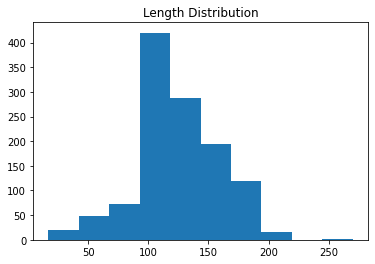

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

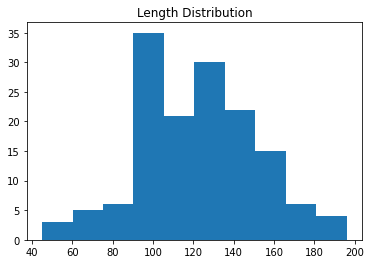

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

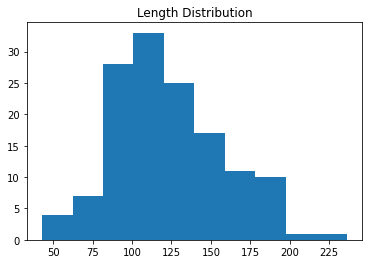

Parameter 'function'=<function DatasetLoader.preprocess_function at 0x7fa21c114200> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5917
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1184
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 5917
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1184
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5917
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1110


Epoch,Training Loss,Validation Loss
1,1.345300,1.514629
2,0.711100,1.520786
3,0.570400,1.619204


***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




### Evaluating Model ###


Disabling tokenizer parallelism, we're using DataLoader multithreading already


تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.9462850093841553, 'start': 15, 'end': 19, 'answer': '۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 57.02592087312415, 'f1': 78.45450893098601}


Configuration saved in bert-base-parsbert-uncased_pquad/config.json
Model weights saved in bert-base-parsbert-uncased_pquad/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/619M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad
   b114e71..6b6e9d0  main -> main

tokenizer config file saved in bert-base-parsbert-uncased_pquad/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased_pquad/special_tokens_map.json
To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad
   6b6e9d0..a4439c8  main -> main



In [5]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
dataset = DATASETS["pquad"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()
trainer.push_to_hub("bert-base-parsbert-uncased_pquad")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_c

### Loading Tokenizer ###


loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b80b05f64dc19f3c880b7074ef09108d0bc244e4b6f50d6dba094da0f1c231fd.6699f2ee4745b6531f79b9781879071b6ace2d2768df83889391421fb44d4474
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05

### Loading Dataset ###


Converting json to dataset:   0%|          | 0/901 [00:00<?, ?it/s]

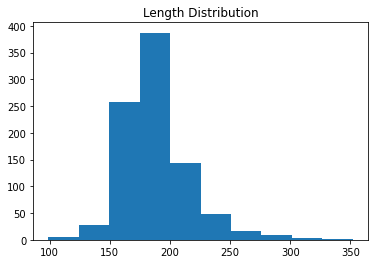

Converting json to dataset:   0%|          | 0/93 [00:00<?, ?it/s]

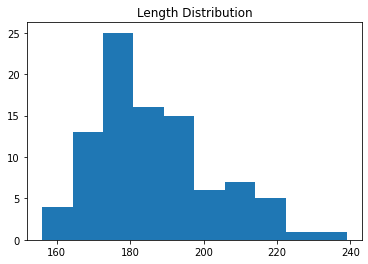

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

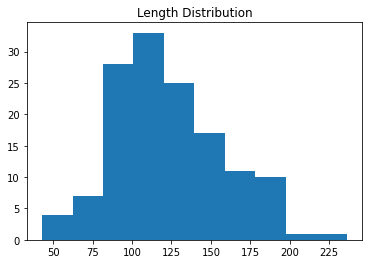

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

loading weights file https://huggingface.co/HooshvareL

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 6306
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1302
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 6306
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1302
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6306
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1185


Epoch,Training Loss,Validation Loss
1,2.806000,2.328210
2,1.895900,2.149322
3,1.571000,2.220667


***** Running Evaluation *****
  Num examples = 1302
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1302
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1302
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




### Evaluating Model ###
تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.238730326294899, 'start': 8, 'end': 19, 'answer': 'در سال ۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 43.38335607094134, 'f1': 68.27823270914114}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='bert-base-parsbert-uncased_persian_qa' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_persian_qa into local empty directory.
Configuration saved in bert-base-parsbert-uncased_persian_qa/config.json
Model weights saved in bert-base-parsbert-uncased_persian_qa/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/619M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_persian_qa
   142cd14..1d9bef9  main -> main

tokenizer config file saved in bert-base-parsbert-uncased_persian_qa/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased_persian_qa/special_tokens_map.json
To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_persian_qa
   1d9bef9..39f1452  main -> main



In [6]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
dataset = DATASETS["persian_qa"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()
trainer.push_to_hub("bert-base-parsbert-uncased_persian_qa")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_c

### Loading Tokenizer ###


loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b80b05f64dc19f3c880b7074ef09108d0bc244e4b6f50d6dba094da0f1c231fd.6699f2ee4745b6531f79b9781879071b6ace2d2768df83889391421fb44d4474
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05

### Loading Dataset ###


Converting json to dataset:   0%|          | 0/136 [00:00<?, ?it/s]

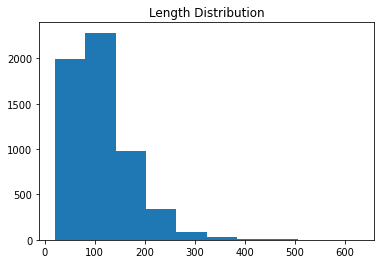

Converting json to dataset:   0%|          | 0/35 [00:00<?, ?it/s]

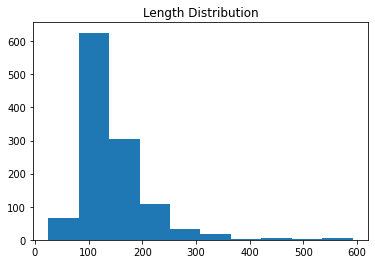

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

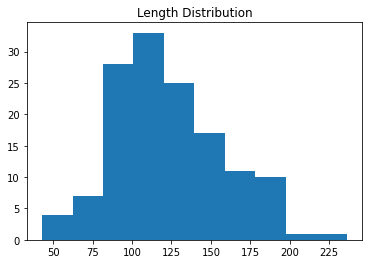

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

loading weights file https://huggingface.co/HooshvareL

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 15517
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 8742
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 15517
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 8742
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15517
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2910


Epoch,Training Loss,Validation Loss
1,1.261600,1.856759
2,0.995900,1.820132
3,0.700200,2.048670


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 8742
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.j

### Evaluating Model ###
تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.8055492043495178, 'start': 15, 'end': 19, 'answer': '۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 52.796725784447474, 'f1': 69.86877786355724}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='bert-base-parsbert-uncased_parsquad' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_parsquad into local empty directory.
Configuration saved in bert-base-parsbert-uncased_parsquad/config.json
Model weights saved in bert-base-parsbert-uncased_parsquad/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/619M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_parsquad
   e4ee8c2..41da204  main -> main

tokenizer config file saved in bert-base-parsbert-uncased_parsquad/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased_parsquad/special_tokens_map.json
To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_parsquad
   41da204..b875383  main -> main



In [7]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
dataset = DATASETS["parsquad"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()
trainer.push_to_hub("bert-base-parsbert-uncased_parsquad")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_c

### Loading Tokenizer ###


loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b80b05f64dc19f3c880b7074ef09108d0bc244e4b6f50d6dba094da0f1c231fd.6699f2ee4745b6531f79b9781879071b6ace2d2768df83889391421fb44d4474
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05

### Loading Dataset ###


Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

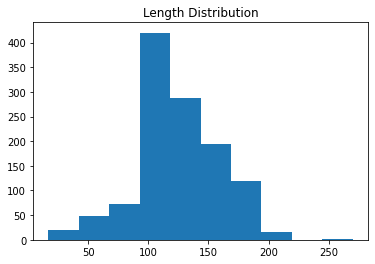

Converting json to dataset:   0%|          | 0/901 [00:00<?, ?it/s]

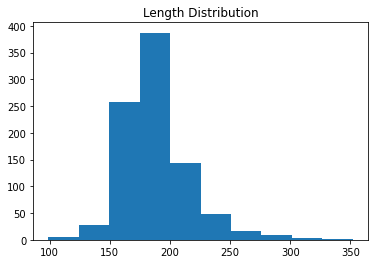

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

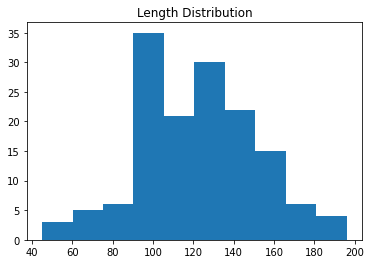

Converting json to dataset:   0%|          | 0/93 [00:00<?, ?it/s]

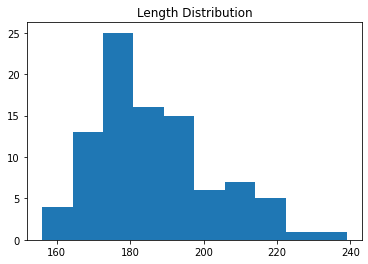

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

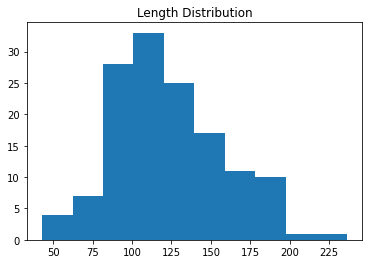

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

loading weights file https://huggingface.co/HooshvareL

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 12223
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 2486
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 12223
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 2486
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12223
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2292


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,1.815100,1.675753
2,1.030300,1.679921
3,0.583000,1.822376


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2486
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.j

### Evaluating Model ###
تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.9521518349647522, 'start': 15, 'end': 19, 'answer': '۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 59.34515688949522, 'f1': 79.58011430218735}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='bert-base-parsbert-uncased_pquad_and_persian_qa' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_and_persian_qa into local empty directory.
Configuration saved in bert-base-parsbert-uncased_pquad_and_persian_qa/config.json
Model weights saved in bert-base-parsbert-uncased_pquad_and_persian_qa/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/619M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_and_persian_qa
   5a1c21c..365a2a2  main -> main

tokenizer config file saved in bert-base-parsbert-uncased_pquad_and_persian_qa/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased_pquad_and_persian_qa/special_tokens_map.json
To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_and_persian_qa
   365a2a2..44229ce  main -> main



In [8]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
dataset = DATASETS["pquad_and_persian_qa"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()
trainer.push_to_hub("bert-base-parsbert-uncased_pquad_and_persian_qa")

## ALBERT

### Loading Tokenizer ###
### Loading Dataset ###


Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

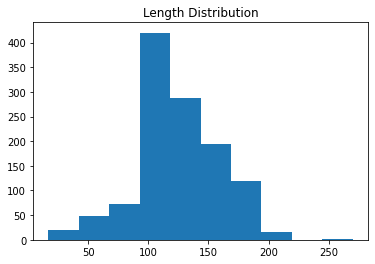

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

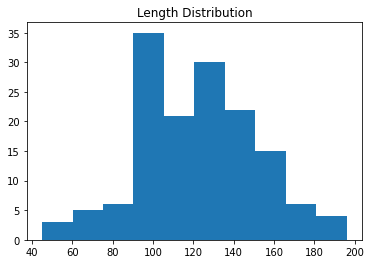

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

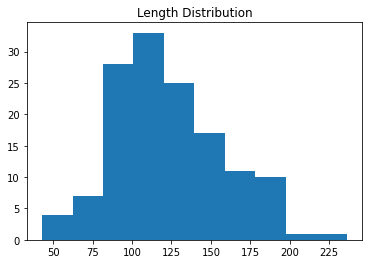

Parameter 'function'=<function DatasetLoader.preprocess_function at 0x7f89a82f0200> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5917
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1184
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 5917
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1184
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Downloading:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.dense.weight', 'predictions.bias', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5917
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1110


Epoch,Training Loss,Validation Loss
1,1.313200,1.596055
2,0.773700,1.573966
3,0.574700,1.694198


***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




### Evaluating Model ###


Disabling tokenizer parallelism, we're using DataLoader multithreading already


تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.9836439490318298, 'start': 14, 'end': 19, 'answer': ' ۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 49.931787175989086, 'f1': 73.16670892152278}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='albert-fa-base-v2_pquad' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_pquad into local empty directory.
Configuration saved in albert-fa-base-v2_pquad/config.json
Model weights saved in albert-fa-base-v2_pquad/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/66.7M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_pquad
   bba70a3..144e82a  main -> main

tokenizer config file saved in albert-fa-base-v2_pquad/tokenizer_config.json
Special tokens file saved in albert-fa-base-v2_pquad/special_tokens_map.json


Upload file spiece.model:   0%|          | 3.34k/1.80M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_pquad
   144e82a..7aeb2b3  main -> main



In [5]:
model_checkpoint = "m3hrdadfi/albert-fa-base-v2"
dataset = DATASETS["pquad"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()
trainer.push_to_hub("albert-fa-base-v2_pquad")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd930e1c7b974b16e37057
Model config AlbertConfig {
  "_name_or_path": "m3hrdadfi/albert-fa-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hid

### Loading Tokenizer ###


loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/fd63765d4a1281488769e542caf7d4bb057020d59666086dc97211de644ad1e6.1ae743a1fcd01622e9a3b03a0842171bca58fa2e107e023e24048d47c30e586f
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd9

### Loading Dataset ###


Converting json to dataset:   0%|          | 0/901 [00:00<?, ?it/s]

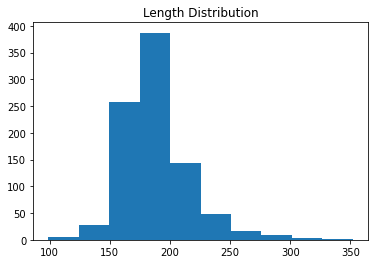

Converting json to dataset:   0%|          | 0/93 [00:00<?, ?it/s]

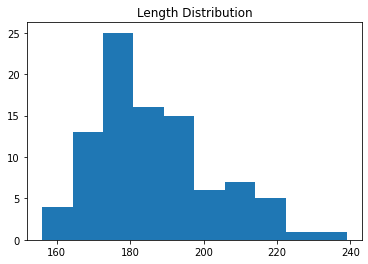

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

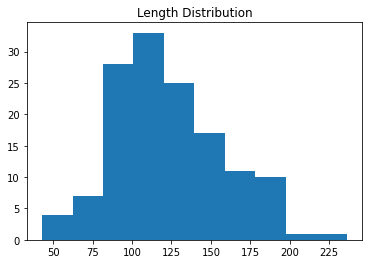

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd930e1c7b974b16e37057
Model config AlbertConfig {
  "_name_or_path": "m3hrdadfi/albert-fa-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 6306
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1302
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 6306
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1302
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.dense.weight', 'predictions.bias', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6306
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1185


Epoch,Training Loss,Validation Loss
1,2.454100,2.311774
2,1.865600,2.161770
3,1.396800,2.273769


***** Running Evaluation *****
  Num examples = 1302
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1302
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1302
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




### Evaluating Model ###
تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.5821070671081543, 'start': 7, 'end': 19, 'answer': ' در سال ۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 40.791268758526606, 'f1': 66.9052405879214}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='albert-fa-base-v2_persian_qa' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_persian_qa into local empty directory.
Configuration saved in albert-fa-base-v2_persian_qa/config.json
Model weights saved in albert-fa-base-v2_persian_qa/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/66.7M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_persian_qa
   80b7f23..070c376  main -> main

tokenizer config file saved in albert-fa-base-v2_persian_qa/tokenizer_config.json
Special tokens file saved in albert-fa-base-v2_persian_qa/special_tokens_map.json


Upload file spiece.model:   0%|          | 3.34k/1.80M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_persian_qa
   070c376..0fd36b6  main -> main



In [6]:
model_checkpoint = "m3hrdadfi/albert-fa-base-v2"
dataset = DATASETS["persian_qa"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()
trainer.push_to_hub("albert-fa-base-v2_persian_qa")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd930e1c7b974b16e37057
Model config AlbertConfig {
  "_name_or_path": "m3hrdadfi/albert-fa-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hid

### Loading Tokenizer ###


loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/fd63765d4a1281488769e542caf7d4bb057020d59666086dc97211de644ad1e6.1ae743a1fcd01622e9a3b03a0842171bca58fa2e107e023e24048d47c30e586f
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd9

### Loading Dataset ###


Converting json to dataset:   0%|          | 0/136 [00:00<?, ?it/s]

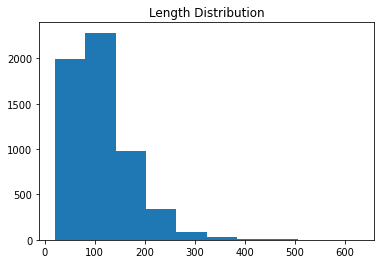

Converting json to dataset:   0%|          | 0/35 [00:00<?, ?it/s]

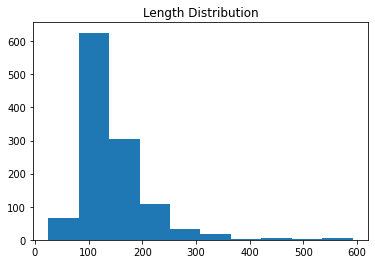

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

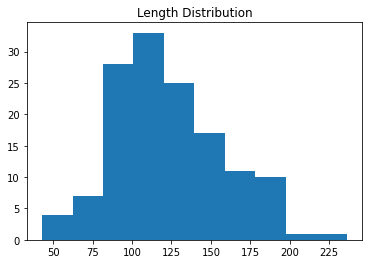

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd930e1c7b974b16e37057
Model config AlbertConfig {
  "_name_or_path": "m3hrdadfi/albert-fa-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 15517
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 8742
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 15517
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 8742
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.dense.weight', 'predictions.bias', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15517
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2910


Epoch,Training Loss,Validation Loss
1,1.276000,1.817525
2,0.993400,1.833020
3,0.769300,2.000509


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 8742
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.j

### Evaluating Model ###
تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.9629366993904114, 'start': 14, 'end': 19, 'answer': ' ۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 45.839017735334245, 'f1': 67.19522968538176}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='albert-fa-base-v2_parsquad' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_parsquad into local empty directory.
Configuration saved in albert-fa-base-v2_parsquad/config.json
Model weights saved in albert-fa-base-v2_parsquad/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/66.7M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_parsquad
   f49366d..61d17ce  main -> main

tokenizer config file saved in albert-fa-base-v2_parsquad/tokenizer_config.json
Special tokens file saved in albert-fa-base-v2_parsquad/special_tokens_map.json


Upload file spiece.model:   0%|          | 3.34k/1.80M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_parsquad
   61d17ce..179a53a  main -> main



In [7]:
model_checkpoint = "m3hrdadfi/albert-fa-base-v2"
dataset = DATASETS["parsquad"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()
trainer.push_to_hub("albert-fa-base-v2_parsquad")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd930e1c7b974b16e37057
Model config AlbertConfig {
  "_name_or_path": "m3hrdadfi/albert-fa-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hid

### Loading Tokenizer ###


loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/fd63765d4a1281488769e542caf7d4bb057020d59666086dc97211de644ad1e6.1ae743a1fcd01622e9a3b03a0842171bca58fa2e107e023e24048d47c30e586f
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd9

### Loading Dataset ###


Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

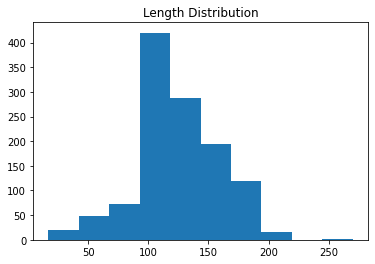

Converting json to dataset:   0%|          | 0/901 [00:00<?, ?it/s]

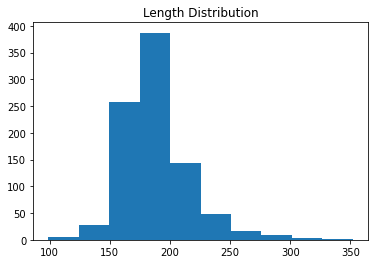

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

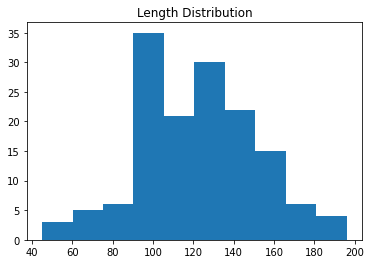

Converting json to dataset:   0%|          | 0/93 [00:00<?, ?it/s]

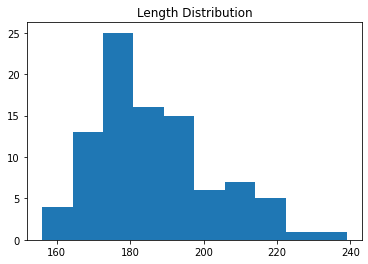

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

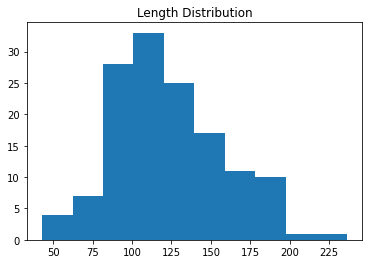

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd930e1c7b974b16e37057
Model config AlbertConfig {
  "_name_or_path": "m3hrdadfi/albert-fa-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 12223
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 2486
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 12223
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 2486
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.dense.weight', 'predictions.bias', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12223
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2292


Epoch,Training Loss,Validation Loss
1,1.744200,1.695394
2,1.068300,1.660845
3,0.640600,1.813202


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2486
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.j

### Evaluating Model ###
تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.9354956150054932, 'start': 14, 'end': 19, 'answer': ' ۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 51.841746248294676, 'f1': 75.72671789957992}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='albert-fa-base-v2_pquad_and_persian_qa' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_pquad_and_persian_qa into local empty directory.
Configuration saved in albert-fa-base-v2_pquad_and_persian_qa/config.json
Model weights saved in albert-fa-base-v2_pquad_and_persian_qa/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/66.7M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_pquad_and_persian_qa
   8c3df59..f8a4a30  main -> main

tokenizer config file saved in albert-fa-base-v2_pquad_and_persian_qa/tokenizer_config.json
Special tokens file saved in albert-fa-base-v2_pquad_and_persian_qa/special_tokens_map.json


Upload file spiece.model:   0%|          | 3.34k/1.80M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/albert-fa-base-v2_pquad_and_persian_qa
   f8a4a30..72fbfa8  main -> main



In [8]:
model_checkpoint = "m3hrdadfi/albert-fa-base-v2"
dataset = DATASETS["pquad_and_persian_qa"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()
trainer.push_to_hub("albert-fa-base-v2_pquad_and_persian_qa")

# Ablations

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_c

### Loading Tokenizer ###


loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b80b05f64dc19f3c880b7074ef09108d0bc244e4b6f50d6dba094da0f1c231fd.6699f2ee4745b6531f79b9781879071b6ace2d2768df83889391421fb44d4474
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05

### Loading Dataset ###


Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

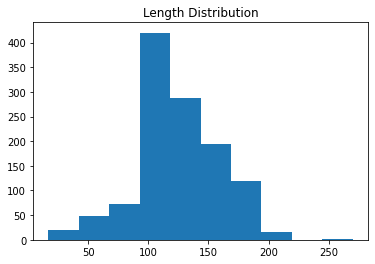

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

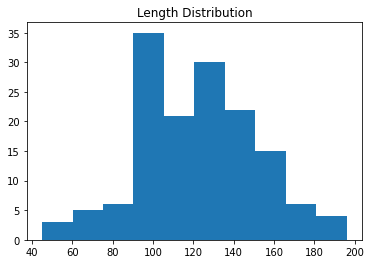

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

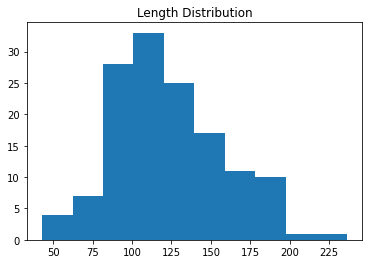

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

loading weights file https://huggingface.co/HooshvareL

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5917
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1184
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 5917
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1184
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5917
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 370


Epoch,Training Loss,Validation Loss
1,1.550000,1.695953


***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




### Evaluating Model ###
تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.8593599200248718, 'start': 15, 'end': 19, 'answer': '۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 54.70668485675307, 'f1': 74.21113530614612}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='bert-base-parsbert-uncased_pquad_1epoch' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_1epoch into local empty directory.
Configuration saved in bert-base-parsbert-uncased_pquad_1epoch/config.json
Model weights saved in bert-base-parsbert-uncased_pquad_1epoch/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/619M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_1epoch
   61fb8fc..1a83924  main -> main

tokenizer config file saved in bert-base-parsbert-uncased_pquad_1epoch/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased_pquad_1epoch/special_tokens_map.json
To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_1epoch
   1a83924..c1f5f4b  main -> main



In [11]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
dataset = DATASETS["pquad"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train(num_train_epochs=1)
trainer.evaluate()
trainer.push_to_hub("bert-base-parsbert-uncased_pquad_1epoch")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_c

### Loading Tokenizer ###


loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b80b05f64dc19f3c880b7074ef09108d0bc244e4b6f50d6dba094da0f1c231fd.6699f2ee4745b6531f79b9781879071b6ace2d2768df83889391421fb44d4474
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05

### Loading Dataset ###


Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

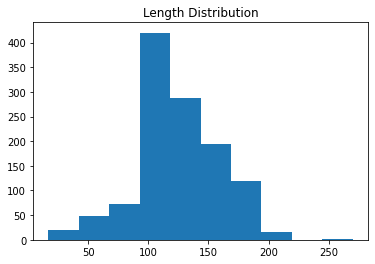

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

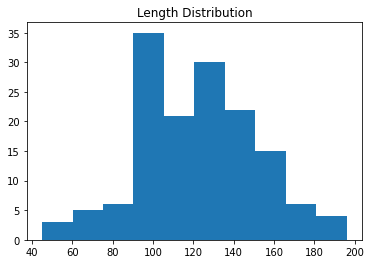

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

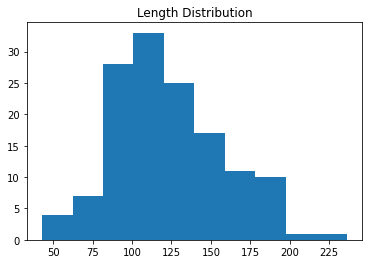

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

loading weights file https://huggingface.co/HooshvareL

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5917
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1184
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1048
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 5917
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1184
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1048
    })
})
### Loading Model ###


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

### Training Model ###


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5917
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1110


Epoch,Training Loss,Validation Loss
1,1.674000,1.779795
2,1.015000,1.637098
3,0.983600,1.632841


***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1184
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




### Evaluating Model ###
تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟
این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵ عنوان قهرمانی در جام حذفی آلمان به‌همراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در جام یوفا شده‌است. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کومرتسبانک آرنا تغییر یافت.
{'score': 0.8922020792961121, 'start': 15, 'end': 19, 'answer': '۱۸۹۹'}


0it [00:00, ?it/s]

{'exact_match': 54.979536152796726, 'f1': 76.21874003041727}


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='bert-base-parsbert-uncased_pquad_lr1e-5' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_lr1e-5 into local empty directory.
Configuration saved in bert-base-parsbert-uncased_pquad_lr1e-5/config.json
Model weights saved in bert-base-parsbert-uncased_pquad_lr1e-5/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/619M [00:00<?, ?B/s]

To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_lr1e-5
   cfe5873..2180d9c  main -> main

tokenizer config file saved in bert-base-parsbert-uncased_pquad_lr1e-5/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased_pquad_lr1e-5/special_tokens_map.json
To https://huggingface.co/mohsenfayyaz/bert-base-parsbert-uncased_pquad_lr1e-5
   2180d9c..8aa35d7  main -> main



In [13]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
dataset = DATASETS["pquad"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train(num_train_epochs=3, learning_rate=1e-5)
trainer.evaluate()
trainer.push_to_hub("bert-base-parsbert-uncased_pquad_lr1e-5")